In [1]:
import os 
import time
import copy

import torch 
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

import matplotlib.pyplot as plt
import numpy as np

using device cuda:0


In [2]:
path = !pwd
path = path[0]
print(path)
mdl_savefile = path+"/models/resnet56_cumultrain_parameters.pickle"
mdl_loadfile = mdl_savefile

/home/ola/Documents/DD2424project


### Functions 

In [3]:
def show_model(model):
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
def make_oneh(labels):
    oneh_labels = np.zeros([labels.shape[0], 10])
    indexes = np.array([np.arange(0,labels.shape[0]), labels.numpy()])
    oneh_labels[tuple(indexes)] = 1.0
    return torch.tensor(oneh_labels).long()
def get_xent_acc(prediction, labels):
    predicted_labels = np.argmax(prediction.cpu().data.numpy(),1)
    (predicted_labels - labels.cpu().data.numpy())
    return sum((predicted_labels - labels.cpu().data.numpy()) == 0)/predicted_labels.shape[0]
def xent_softmax(prediction):
    pred = np.exp(prediction.cpu().data.numpy())
    divide = np.repeat(pred.sum(1).reshape(pred.shape[0],1), pred.shape[1],1)
    pred = np.divide(pred,divide)
    return pred 
def get_valacc(valacc, valloss):
    with torch.no_grad():
        f"""certain layers have different properties during evaluation e.g dropout. 
            therefor we use resnet.eval()"""
        resnet.eval()      
        for i, (valimgs, vallabels) in enumerate(valid_data_loader):
            if cuda_available: 
                valimgs   = valimgs.cuda()
                vallabels = vallabels.cuda()
            valprediction = resnet.forward(valimgs)    
            valloss = valloss + [loss_xent(valprediction, vallabels)]
            valacc = valacc + [get_xent_acc(valprediction, vallabels)]
            break
        f"""reset resnet for training with resnet.train()"""
        resnet.train()
    return valacc, valloss
def compare_parameters(net1, net2):
    f"""compare parameters of two models with the same architecture""" 
    net1_param, net2_param, diff = [], [], 0
    for param_tensor in net1.state_dict():
        net1_param = net1_param + [net1.state_dict()[param_tensor]]
        net2_param = net2_param + [net2.state_dict()[param_tensor]]
    for i in range(len(net1_param)):
        diff = diff + np.sum(net1_param[i].cpu().numpy() - net2_param[i].cpu().numpy())
    print(f"""difference in weights and biases is: {diff} between network1 and network2""")

### ResNet-56 https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py

In [4]:
def _weights_init(m):
    classname = m.__class__.__name__
    print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal(m.weight)
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

### load data

In [5]:
torchvision.datasets.CIFAR10(path,download=True)
f"""adding transform ToTensor(); transforms PIL-images to tensor-format used by PyTorch""" 
batchsize = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
cifar10_train = torchvision.datasets.CIFAR10(path, train=True, transform=transform)
cifar10_valid = torchvision.datasets.CIFAR10(path, train=False,transform=transform)
dataloader_tr = torch.utils.data.DataLoader(cifar10_train,
                                          batch_size=batchsize,
                                          shuffle=True,
                                          num_workers=0,
                                          pin_memory=True)
dataloader_vl = torch.utils.data.DataLoader(cifar10_valid,
                                          batch_size=batchsize,
                                          shuffle=True,
                                          num_workers=0,
                                          pin_memory=True)

Files already downloaded and verified


### learning-rate range-test

In [11]:
def range_test(net,opt,dataloader,lossfn,max_lr,min_lr,iterations,batchsize):
    scheduler = torch.optim.lr_scheduler.CyclicLR(opt, min_lr, max_lr, 
                                                  step_size_up=iterations, step_size_down=0, 
                                                  mode='triangular', cycle_momentum=False)
    accuracy  = []
    loss      = []
    datait    = iter(dataloader)
    n_batches = len(datait)
    interval  = 5
    batch     = 0
    for i in range(1,iterations):
        batch += 1
        if batch >= n_batches:
            datait = iter(dataloader)
            batch = 0 
        images, labels = datait.next() 
        if cuda_available:
            images, labels = images.cuda(), labels.cuda()
        prediction = net.forward(images)
        output     = lossfn(prediction, labels)
        f"""Use accuracy on training-set"""
        if i % interval == 0:
            accuracy   = accuracy + [get_xent_acc(prediction, labels)]
            loss       = loss + [output]
        opt.zero_grad()   # clear gradients from previous time-step 
        output.backward() # calculates gradients 
        opt.step()        # updates weights
        scheduler.step()  # change learning-rate in range_optimizer
    f"""make and save plot of accuracy"""
    x1, x2 = [np.linspace(min_lr, max_lr, num) for num in [len(accuracy), len(loss)]]
    plt.plot(x1, np.array(accuracy))
    save_file = path+f"""/rangetest/acc_bs{batchsize}_minlr{min_lr}_maxlr{max_lr}_iterations{iterations}.png"""
    plt.savefig(save_file)
    plt.show()
    return accuracy, loss

In [ ]:
%%capture
resnet = ResNet(BasicBlock,[9,9,9])
if cuda_available: resnet.cuda()

Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Sequential
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
LambdaLayer
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
Ba

/home/ola/.conda/envs/everything/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  """


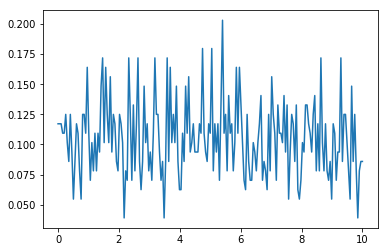

In [15]:
max_lr = 10
min_lr = 0.0001
iterations = 1000
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=min_lr, 
                      momentum=0.95, weight_decay=1e-4)
accuracy, loss = range_test(resnet, optimizer, dataloader_tr, lossfn,max_lr,min_lr,iterations,batchsize)

### network 

In [ ]:
%%capture
f"""To get ResNet56 use ResNet(BasicBlock,[9,9,9])""" 
resnet = ResNet(BasicBlock,[9,9,9])
if cuda_available: 
    resnet.cuda()

### loss-function    https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

In [ ]:
loss_xent = nn.CrossEntropyLoss()

### optimize-function https://pytorch.org/docs/stable/optim.html

In [ ]:
optimizer = optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# play with forward and backwards pass

In [ ]:
start    = time.time()
f"""load previous model"""
# if os.path.isfile(load_filename):
#     resnet.load_state_dict(torch.load(load_filename))
n_epoch  = 1
validation_interval = 10

trainacc  = [] 
valacc    = [] 
trainloss = []
valloss   = [] 

for epoch in range(n_epoch):
    train_iterator = iter(train_data_loader)
    for i in range(len(train_iterator)):
        images, labels = train_iterator.next()
        
        f"""if we use GPU, input- and target-tensors must be loaded on GPU as well."""
        if cuda_available: 
            images = images.cuda()
            labels = labels.cuda()
            
        prediction = resnet.forward(images)
        output     = loss_xent(prediction, labels)
        
        trainacc = trainacc + [get_xent_acc(prediction, labels)]
        trainloss = trainloss + [output]
        
        f"""using zero_grad() seems to be necessary. step() does not clear the gradients"""
        optimizer.zero_grad()
        output.backward() # calculates gradients 
        optimizer.step()  # updates weights
        
        if i % validation_interval == 0:
            valacc, valloss = get_valacc(valacc, valloss)
            
    print(f"""time passed after training {epoch+1} epochs is {time.time()-start} seconds""")

### Plot results 

In [ ]:
x1, x2, x3 = [np.linspace(0, len(trainacc), num) for num in [len(trainloss), len(trainacc), len(valacc)]]

In [ ]:
plt.plot(x1,np.array(trainloss))
plt.show()

In [ ]:
plt.plot(x2,np.array(trainacc))
plt.plot(x3,np.array(valacc))
plt.show()

### Save/Load Model
### https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [ ]:
%%capture 
f"""save"""
torch.save(resnet.state_dict(), save_filename)
f"""load"""
resnet2 = ResNet(BasicBlock,[9,9,9])
resnet2.load_state_dict(torch.load(load_filename))
compare_parameters(resnet,resnet2)

#### DenseNet

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
imshow(torchvision.utils.make_grid(images.cpu()))

In [ ]:
densenet = models.densenet161()